In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import numpy as np
from sklearn.model_selection import cross_val_score

# Odczyt danych z plików csv

In [2]:
train = pd.read_csv('ed-titanic-training.csv')
test = pd.read_csv('ed-titanic-test.csv')

In [3]:
train.head(3)

,Unnamed: 0,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,1,0,2,0,3,1,1,2,0,3
2,2,1,3,0,1,0,1,0,0,1,1,4


# Wyznaczenie korelacji Pearsona pomiędzy cechami zbioru treningowego i testowego wraz z wizualizacją macierzy korelacji

     Survived  Pclass  Sex  Age  Parch  Fare  Embarked  Has_Cabin  FamilySize  \
0           0       3    1    1      0     0         0          0           2   
1           1       1    0    2      0     3         1          1           2   
2           1       3    0    1      0     1         0          0           1   
3           1       1    0    2      0     3         0          1           2   
4           0       3    1    2      0     1         0          0           1   
..        ...     ...  ...  ...    ...   ...       ...        ...         ...   
886         0       2    1    1      0     1         0          0           1   
887         1       1    0    1      0     2         0          1           1   
888         0       3    0    2      2     2         0          0           4   
889         1       1    1    1      0     2         1          1           1   
890         0       3    1    1      0     0         2          0           1   

     IsAlone  Title  
0    

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

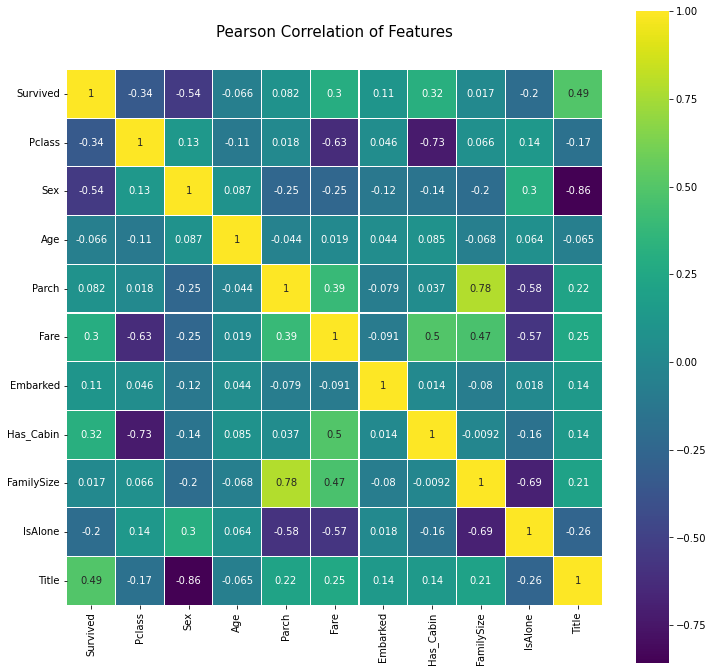

In [4]:
train = train.iloc[:,1:]
test = test.iloc[:,1:]
print(train)
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,
square=True, cmap=colormap, linecolor='white', annot=True)


# Płeć wykazuje największą negatywną korelację z etykietą przeżycia, natomiast tytuł wykazuje największą pozytywną korelację z tą etykietą

# Współczynnik przeżywalności dla każdego z tytułów

In [5]:
train[['Title', 'Survived']].groupby('Title').mean()

,Survived
Title,
1,0.156673
2,0.575000
3,0.793651
4,0.702703
5,0.347826


# Sprawdzenie kryteriów podziału oraz wyznaczenie najlepszej głębokości drzewa z użyciem walidacji krzyżowej (10-fold)

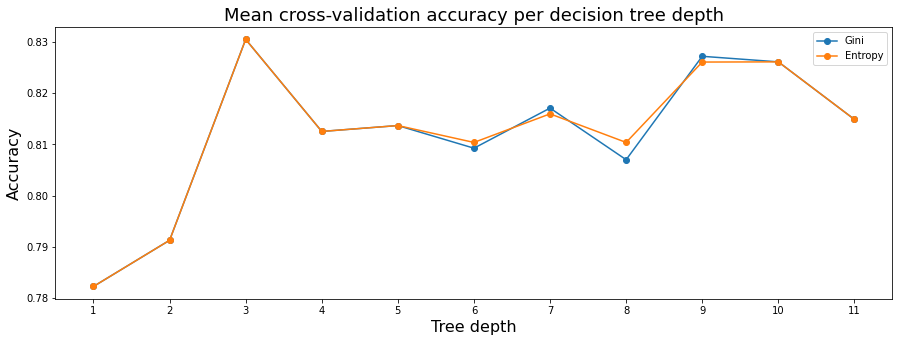

In [6]:
x_train = train.drop(['Survived'], axis=1)
y_train = train['Survived']
max_attributes = len(list(train))
max_depths = range(1, max_attributes + 1)

def run_cross_valdation(x, y, max_depths, max_sample_leaf=None, criterion='gini'):
    cv_scores_list = []
    cv_scores_mean = []
    for max_depth in max_depths:
        decision_tree = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)
        cv_scores = cross_val_score(decision_tree, x, y, cv=10, scoring='accuracy')
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
    cv_scores_mean = np.array(cv_scores_mean)
    return cv_scores_mean


gini_cv_scores_mean = run_cross_valdation(x_train, y_train, max_depths, 'gini')
entropy_cv_scores_mean = run_cross_valdation(x_train, y_train, max_depths, 'entropy')

fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(max_depths, gini_cv_scores_mean, '-o', label='Gini')
ax.plot(max_depths, entropy_cv_scores_mean, '-o', label='Entropy')
ax.set_xticks(max_depths)
ax.set_xlabel('Tree depth', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_title('Mean cross-validation accuracy per decision tree depth', fontsize=18)
ax.legend()

# Budowa drzewa decyzyjnego na podstawie wyliczonej wcześniej głębokości równej 3, dla kryterium podziału entropy

In [7]:
decision_tree = tree.DecisionTreeClassifier(max_depth = 3, criterion='entropy')
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

# Zapisywanie predykcji dla danych testowych

In [8]:
prediction = decision_tree.predict(test)
np.savetxt('decision_tree_prediction.txt', prediction, '%0.0f')

# Wizualizacja drzewa decyzyjnego za pomocą matplotlib

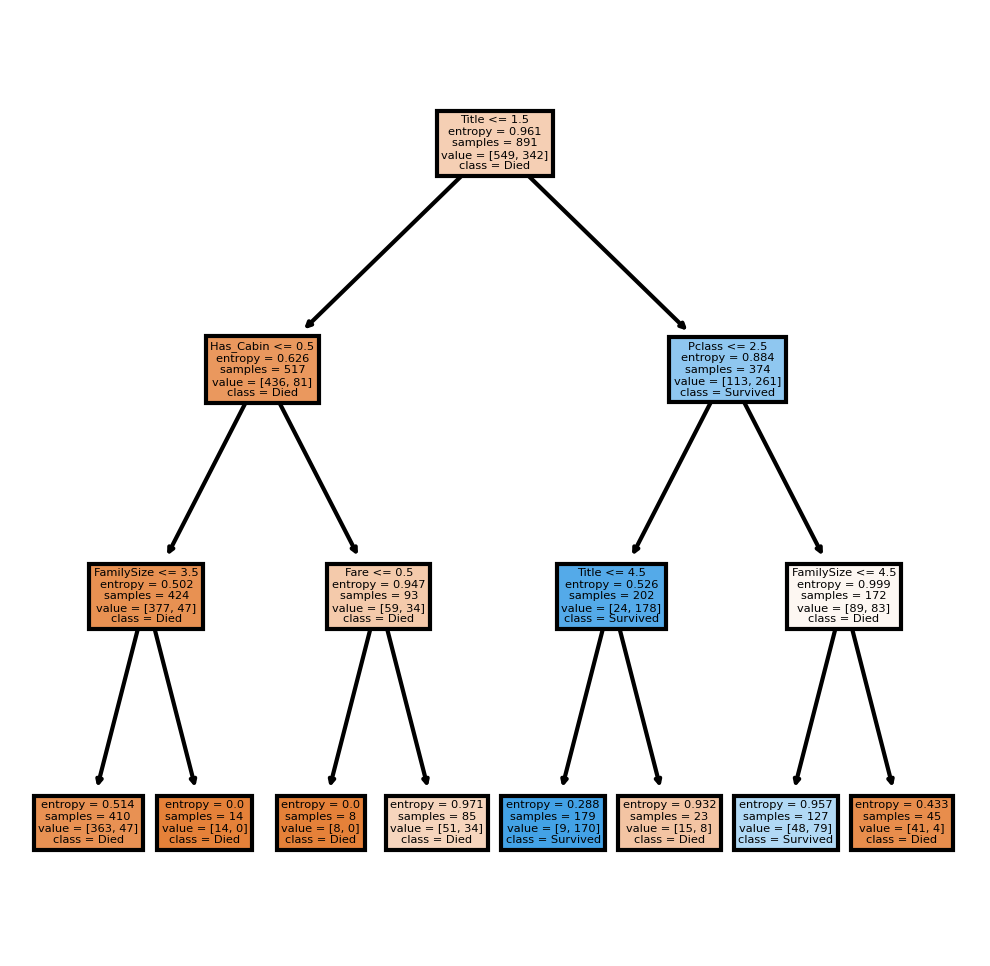

In [9]:
fn=list(train.drop(['Survived'], axis = 1))
cn=['Died', 'Survived']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(decision_tree,
               feature_names = fn, 
               class_names=cn,
               filled = True);

# CV score dla różnych minimalnych rozmiarów liścia i głębokości

In [10]:
min_sample_leaf = range(1,10)
cv_scores_list = []
cv_scores_mean = []
i = 1
while i in min_sample_leaf:
    for max_depth in max_depths:
        decision_tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = i, criterion='gini')
        cv_scores = cross_val_score(decision_tree, x_train, y_train, cv=10, scoring='accuracy')
        print(f'max depth: {max_depth} min_sample_leaf: {i} accuracy: {np.array(cv_scores.mean())}')
    i = i + 1
    print("")



max depth: 1 min_sample_leaf: 1 accuracy: 0.7822846441947565
max depth: 2 min_sample_leaf: 1 accuracy: 0.7912983770287141
max depth: 3 min_sample_leaf: 1 accuracy: 0.8305243445692885
max depth: 4 min_sample_leaf: 1 accuracy: 0.8125468164794007
max depth: 5 min_sample_leaf: 1 accuracy: 0.8103245942571785
max depth: 6 min_sample_leaf: 1 accuracy: 0.8070287141073658
max depth: 7 min_sample_leaf: 1 accuracy: 0.813732833957553
max depth: 8 min_sample_leaf: 1 accuracy: 0.8081523096129837
max depth: 9 min_sample_leaf: 1 accuracy: 0.8272159800249689
max depth: 10 min_sample_leaf: 1 accuracy: 0.8216354556803995
max depth: 11 min_sample_leaf: 1 accuracy: 0.8205118601747815

max depth: 1 min_sample_leaf: 2 accuracy: 0.7822846441947565
max depth: 2 min_sample_leaf: 2 accuracy: 0.7912983770287141
max depth: 3 min_sample_leaf: 2 accuracy: 0.8305243445692885
max depth: 4 min_sample_leaf: 2 accuracy: 0.8125468164794007
max depth: 5 min_sample_leaf: 2 accuracy: 0.8148189762796504
max depth: 6 min_sampl

# Wyznaczenie macierzy rozbieżności (dla 25% danych testowych)

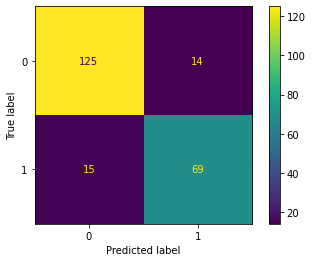

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
decision_tree.fit(x_train, y_train)
X_train, X_test, Y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, random_state=0)
plot_confusion_matrix(decision_tree, X_test, y_test)  

# Wyznaczenie miar dokładności modelu

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = decision_tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       139
           1       0.83      0.82      0.83        84

    accuracy                           0.87       223
   macro avg       0.86      0.86      0.86       223
weighted avg       0.87      0.87      0.87       223



# Odczyt zbioru danych Iris

In [13]:
from sklearn.datasets import load_iris
iris = load_iris()

X, y = load_iris(return_X_y=True)

# Wykorzystanie klasyfikatora KNN z 10-krotną walidacją krzyżową do zbadania dokładności dla metryki euklidesowej i taxi (Iris)

In [14]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
from sklearn.neighbors import KNeighborsClassifier as KNN
for k in [1,3,5,7]:
    print(f'\n Measuring accuracy of the KNN model with {k} neighbours')
    for metric in ['euclidean', 'manhattan' ]:
        print(f'\n Metric = {metric}')
        for weights in ['uniform', 'distance']:
            knn = KNN(n_neighbors = k, metric = metric, weights = weights)
            res = cross_val_score(knn, X_train, y_train, cv=10).mean()
            print(f'weights = {weights}, result = {res}')


 Measuring accuracy of the KNN model with 1 neighbours

 Metric = euclidean
weights = uniform, result = 0.96
weights = distance, result = 0.96

 Metric = manhattan
weights = uniform, result = 0.95
weights = distance, result = 0.95

 Measuring accuracy of the KNN model with 3 neighbours

 Metric = euclidean
weights = uniform, result = 0.96
weights = distance, result = 0.96

 Metric = manhattan
weights = uniform, result = 0.96
weights = distance, result = 0.96

 Measuring accuracy of the KNN model with 5 neighbours

 Metric = euclidean
weights = uniform, result = 0.96
weights = distance, result = 0.96

 Metric = manhattan
weights = uniform, result = 0.96
weights = distance, result = 0.96

 Measuring accuracy of the KNN model with 7 neighbours

 Metric = euclidean
weights = uniform, result = 0.97
weights = distance, result = 0.9800000000000001

 Metric = manhattan
weights = uniform, result = 0.96
weights = distance, result = 0.96


# Odczyt, odfiltrowanie i redukcja wymiarowości danych NYT do 10 (PCA)

In [15]:
from sklearn.decomposition import PCA
df = pd.read_csv('./nyt-frame.csv', header = 0)
data = df.iloc[:,9:]
array = data.values
pca = PCA(n_components = 10)
X_pca = pca.fit_transform(array)

# Wykorzystanie klasyfikatora KNN z 10-krotną walidacją krzyżową do zbadania dokładności dla metryki euklidesowej i taxi (NYT)

In [16]:
y_nyt = np.array(df['class.labels'])
print(y_nyt)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_nyt, test_size=0.33, random_state=42, stratify=y_nyt)
from sklearn.neighbors import KNeighborsClassifier as KNN
for k in [1,3,5,7]:
    print(f'\nKNN model accuracy for NYT dataset for {k} neighbours')
    for metric in ['euclidean', 'manhattan' ]:
        print(f'\nGiven metric = {metric}')
        for weights in ['uniform', 'distance']:
            knn = KNN(n_neighbors = k, metric = metric, weights = weights)
            res = cross_val_score(knn, X_train, y_train, cv=10).mean()
            print(f'weights = {weights}, accuracy = {res}')

['art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art'
 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art'
 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art'
 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art'
 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'art' 'music' 'music'
 'music' 'music' 'music' 'music' 'music' 'music' 'music' 'music' 'music'
 'music' 'music' 'music' 'music' 'music' 'music' 'music' 'music' 'music'
 'music' 'music' 'music' 'music' 'music' 'music' 'music' 'music' 'music'
 'music' 'music' 'music' 'music' 'music' 'music' 'music' 'music' 'music'
 'music' 'music' 'music' 'music' 'music' 'music' 'music']

KNN model accuracy for NYT dataset for 1 neighbours

Given metric = euclidean
weights = uniform, accuracy = 0.9261904761904762
weights = distance, accuracy = 0.9261904761904762

Given metric = manhattan
weights = uniform, accuracy = 0.8809523809523808
weights = distance, accuracy = 0.8

# Wnioski z KNN

### - 10 walidacja krzyżowa - 10 krotne podzielenie zbioru, dla każdego jest liczone accuracy, a później jest uśredniane
### - uczymy model w k iteracjach i uśredniamy wyniki
### - obie metryki dostarczają podobne efekty